In [1]:
import tensorflow as tf
import keras
import pandas as pd
import os

csv_file = 'data/archive/HAM10000_metadata.csv'
img_dir = 'data/hair_removed/'
file_prefix = 'nohair_'

data = pd.read_csv(csv_file)

classes = sorted(data['dx'].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
num_classes = len(classes)

image_paths = [
    os.path.join(img_dir, file_prefix + image_id + '.jpg')
    for image_id in data['image_id']
]
labels = [class_to_idx[label] for label in data['dx']]

dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    image = tf.image.resize(image, [224, 224])
    image = keras.applications.convnext.preprocess_input(image)

    return image, label


dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.shuffle(buffer_size=len(image_paths), seed=42)
train_size = int(0.8 * len(image_paths))
train_dataset = dataset.take(train_size).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = dataset.skip(train_size).batch(32).prefetch(tf.data.AUTOTUNE)

def create_model(num_classes):
    base_model = keras.applications.ConvNeXtTiny(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
    )
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

model = create_model(num_classes)

model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=0.05),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True
    )
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


I0000 00:00:1726775525.464921 1487335 service.cc:146] XLA service 0x34ac87ed0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726775525.464944 1487335 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1726775525.470758 1487335 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 2133s 8s/step - accuracy: 0.4154 - loss: 1.6337 - val_accuracy: 0.6790 - val_loss: 0.9764
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2142s 9s/step - accuracy: 0.6712 - loss: 0.9832 - val_accuracy: 0.6710 - val_loss: 0.9741
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2141s 9s/step - accuracy: 0.6847 - loss: 0.9311 - val_accuracy: 0.6855 - val_loss: 0.9023
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2120s 8s/step - accuracy: 0.6918 - loss: 0.8781 - val_accuracy: 0.6865 - val_loss: 0.8836
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2127s 8s/step - accuracy: 0.6891 - loss: 0.8629 - val_accuracy: 0.6855 - val_loss: 0.8539
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2147s 9s/step - accuracy: 0.6976 - loss: 0.8417 - val_accuracy: 0.6995 - val_loss: 0.8222
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2146s 9s/step - accuracy: 0.7048 - loss: 0.8222 - val_accuracy: 0.7024 - val_loss: 0.8155
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2115s 8s/step - accuracy: 0.7079 - loss: 0.8000 - val_accurac

In [2]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%')

63/63 ━━━━━━━━━━━━━━━━━━━━ 465s 7s/step - accuracy: 0.7711 - loss: 0.6591
Validation Loss: 0.6610, Validation Accuracy: 76.09%


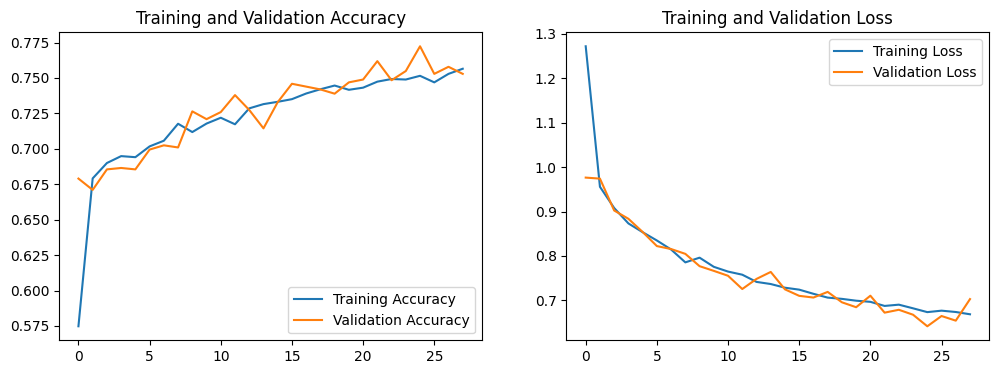

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
epochs_range = range(len(history.history['accuracy']))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()